Optimal k: 12 with cross-validated accuracy: 0.7326

Overall Performance Metrics:
Overall Accuracy: 0.7172
Macro-averaged Sensitivity: 0.7418
Macro-averaged Specificity: 0.9483

Per-Class Performance Metrics:
Class          Sensitivity    Specificity    
---------------------------------------------
Pastry         0.5517         0.9556         
Z_Scratch      0.9024         0.9655         
K_Scratch      0.9157         0.9935         
Stains         0.9231         0.9973         
Dirtiness      0.6250         0.9895         
Bumps          0.6944         0.8549         
Other_Faults   0.5804         0.8821         


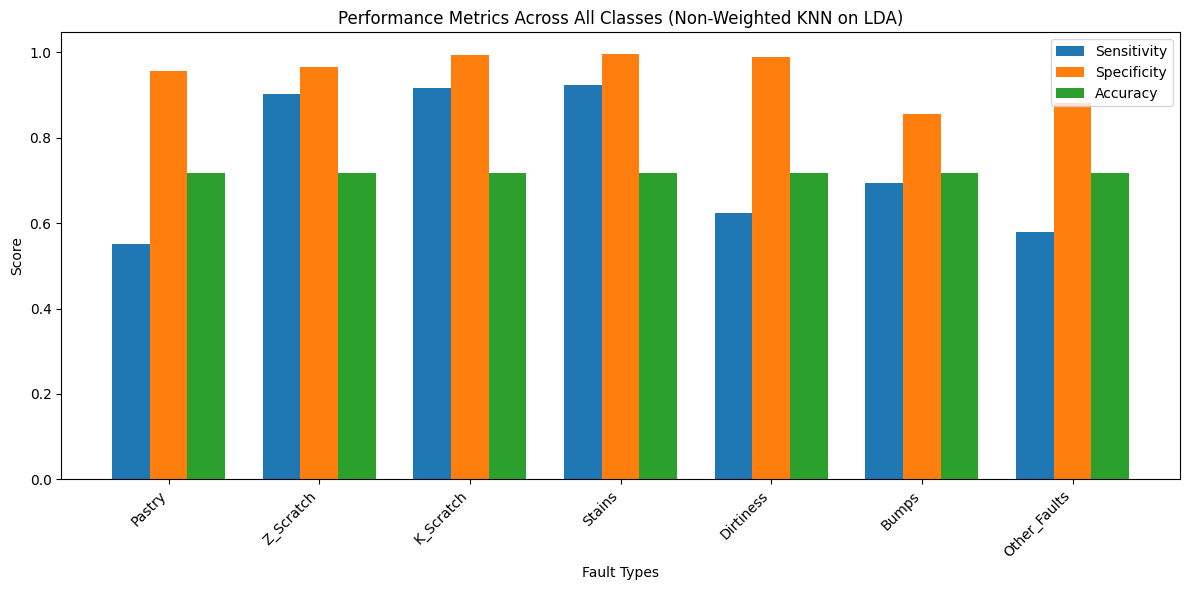

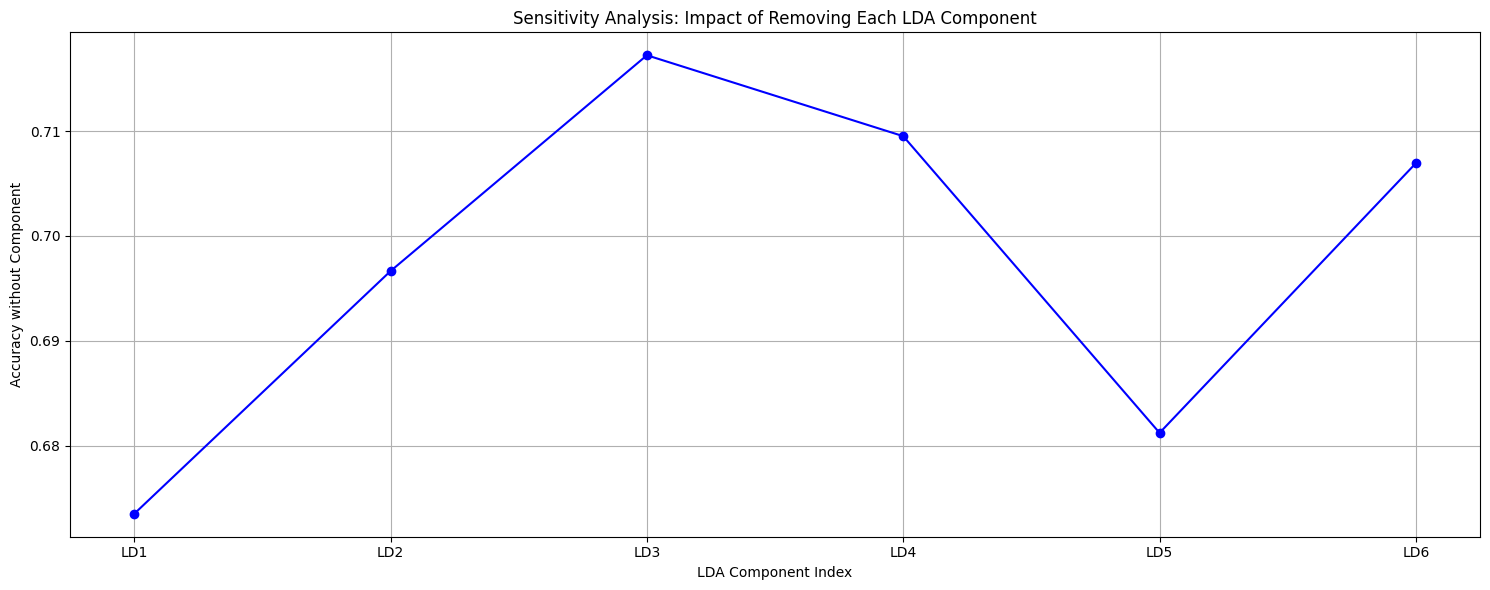

<Figure size 1200x600 with 0 Axes>

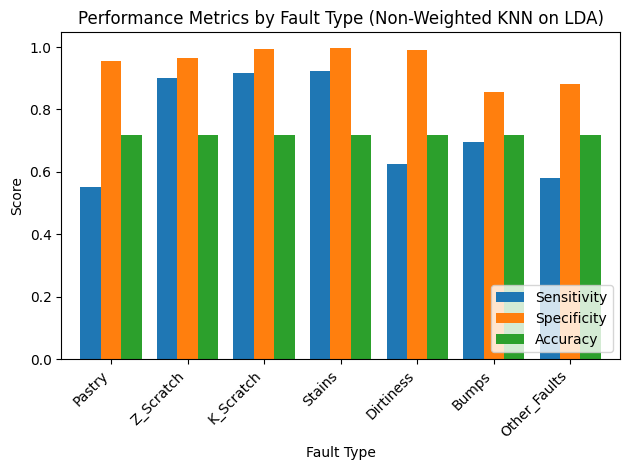

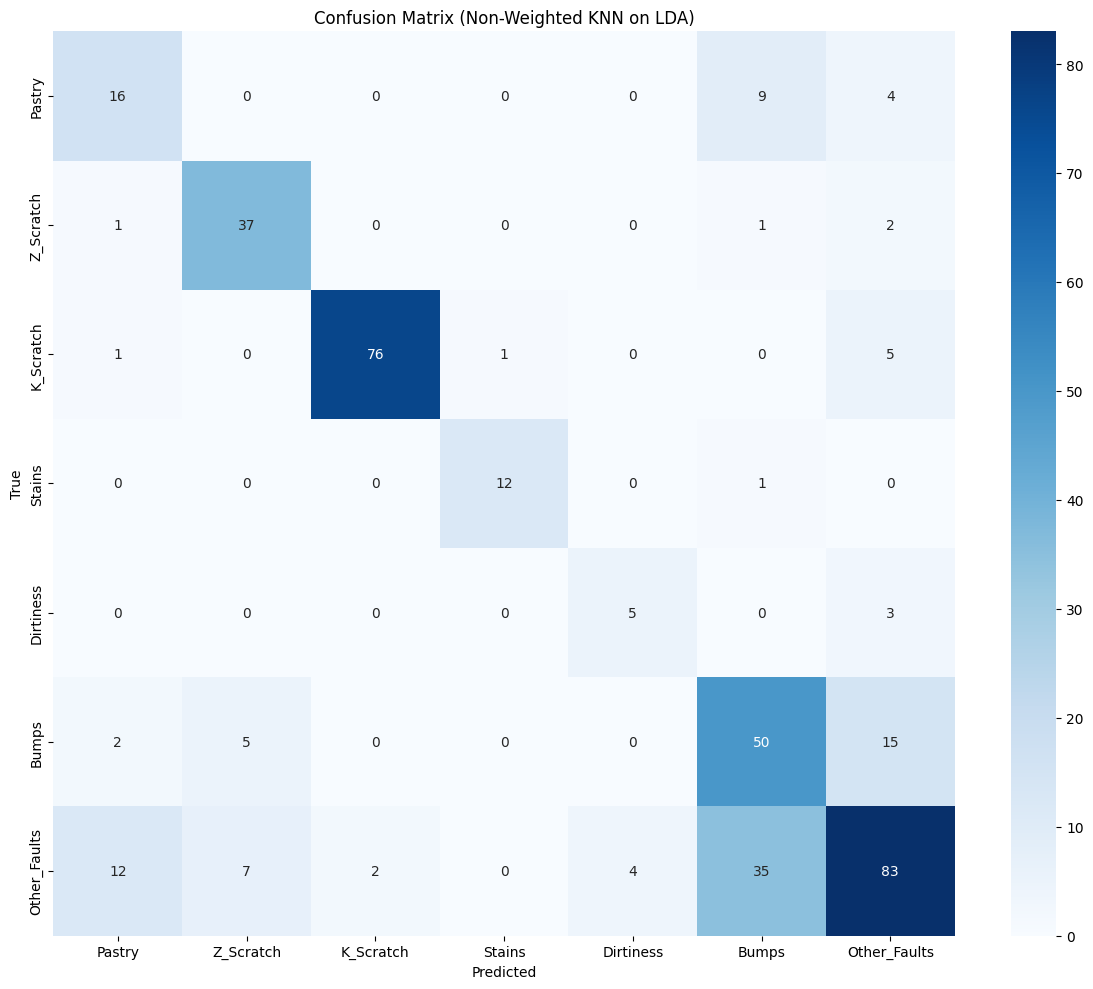

In [2]:
#LDA KNN NON WEIGHTED

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load LDA transformed dataset
file_path = 'lda_transformed.csv'
data = pd.read_csv(file_path)

# Separate features (LD components) and target variables (one-hot encoded classes)
feature_columns = ['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6']
class_columns = ["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

X = data[feature_columns].values
y = data[class_columns].values

# Convert one-hot encoded y to class labels
y_labels = np.argmax(y, axis=1)

def plot_overall_metrics(sensitivity_dict, specificity_dict, accuracy):
    """Plot overall metrics across all classes."""
    plt.figure(figsize=(12, 6))
    
    classes = list(sensitivity_dict.keys())
    sensitivities = [sensitivity_dict[c] for c in classes]
    specificities = [specificity_dict[c] for c in classes]
    accuracies = [accuracy] * len(classes)
    
    x = np.arange(len(classes))
    width = 0.25
    
    plt.bar(x - width, sensitivities, width, label='Sensitivity')
    plt.bar(x, specificities, width, label='Specificity')
    plt.bar(x + width, accuracies, width, label='Accuracy')
    
    plt.xlabel('Fault Types')
    plt.ylabel('Score')
    plt.title('Performance Metrics Across All Classes (Non-Weighted KNN on LDA)')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_sensitivity_analysis(sensitivity_results):
    """Plot sensitivity analysis results for LDA components."""
    plt.figure(figsize=(15, 6))
    
    feature_indices = [r['Feature Index'] for r in sensitivity_results]
    accuracies = [r['Accuracy'] for r in sensitivity_results]
    
    plt.plot(feature_indices, accuracies, 'bo-')
    plt.xlabel('LDA Component Index')
    plt.ylabel('Accuracy without Component')
    plt.title('Sensitivity Analysis: Impact of Removing Each LDA Component')
    plt.xticks(feature_indices, [f'LD{i+1}' for i in feature_indices])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fault_performance(sensitivity_dict, specificity_dict, accuracy):
    """Plot performance metrics per fault type."""
    metrics_df = pd.DataFrame({
        'Fault Type': list(sensitivity_dict.keys()),
        'Sensitivity': list(sensitivity_dict.values()),
        'Specificity': list(specificity_dict.values()),
        'Accuracy': [accuracy] * len(sensitivity_dict)
    })
    
    plt.figure(figsize=(12, 6))
    metrics_df.set_index('Fault Type').plot(kind='bar', width=0.8)
    plt.title('Performance Metrics by Fault Type (Non-Weighted KNN on LDA)')
    plt.xlabel('Fault Type')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, class_labels):
    """Plot comprehensive confusion matrix."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix (Non-Weighted KNN on LDA)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Find optimal k
optimal_k = 1
highest_accuracy = 0

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    
    if mean_accuracy > highest_accuracy:
        highest_accuracy = mean_accuracy
        optimal_k = k

print(f"Optimal k: {optimal_k} with cross-validated accuracy: {highest_accuracy:.4f}")

# Train model with optimal k
knn = KNeighborsClassifier(n_neighbors=optimal_k, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate sensitivity and specificity
sensitivity = {}
specificity = {}
for i, class_label in enumerate(class_columns):
    TP = conf_matrix[i, i]
    FN = sum(conf_matrix[i, :]) - TP
    FP = sum(conf_matrix[:, i]) - TP
    TN = conf_matrix.sum() - (TP + FN + FP)
    
    sensitivity[class_label] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_label] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print overall metrics
print("\nOverall Performance Metrics:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro-averaged Sensitivity: {np.mean(list(sensitivity.values())):.4f}")
print(f"Macro-averaged Specificity: {np.mean(list(specificity.values())):.4f}")

# Print per-class metrics
print("\nPer-Class Performance Metrics:")
print(f"{'Class':<15}{'Sensitivity':<15}{'Specificity':<15}")
print("-" * 45)
for class_label in class_columns:
    print(f"{class_label:<15}{sensitivity[class_label]:<15.4f}{specificity[class_label]:<15.4f}")

# Perform sensitivity analysis on LDA components
sensitivity_results = []
for feature_index in range(X.shape[1]):
    X_train_modified = np.delete(X_train, feature_index, axis=1)
    X_test_modified = np.delete(X_test, feature_index, axis=1)
    
    knn.fit(X_train_modified, y_train)
    y_pred_modified = knn.predict(X_test_modified)
    modified_accuracy = accuracy_score(y_test, y_pred_modified)
    
    sensitivity_results.append({
        'Feature Index': feature_index,
        'Accuracy': modified_accuracy
    })

# Create visualizations
plot_overall_metrics(sensitivity, specificity, accuracy)
plot_sensitivity_analysis(sensitivity_results)
plot_fault_performance(sensitivity, specificity, accuracy)
plot_confusion_matrix(conf_matrix, class_columns)

Optimal k: 19 with cross-validated accuracy: 0.7448

Overall Performance Metrics:
Overall Accuracy: 0.7172
Macro-averaged Sensitivity: 0.7134
Macro-averaged Specificity: 0.9469

Per-Class Performance Metrics:
Class          Sensitivity    Specificity    
---------------------------------------------
Pastry         0.4828         0.9667         
Z_Scratch      0.8780         0.9684         
K_Scratch      0.9277         0.9935         
Stains         0.9231         1.0000         
Dirtiness      0.5000         0.9869         
Bumps          0.6667         0.8675         
Other_Faults   0.6154         0.8455         


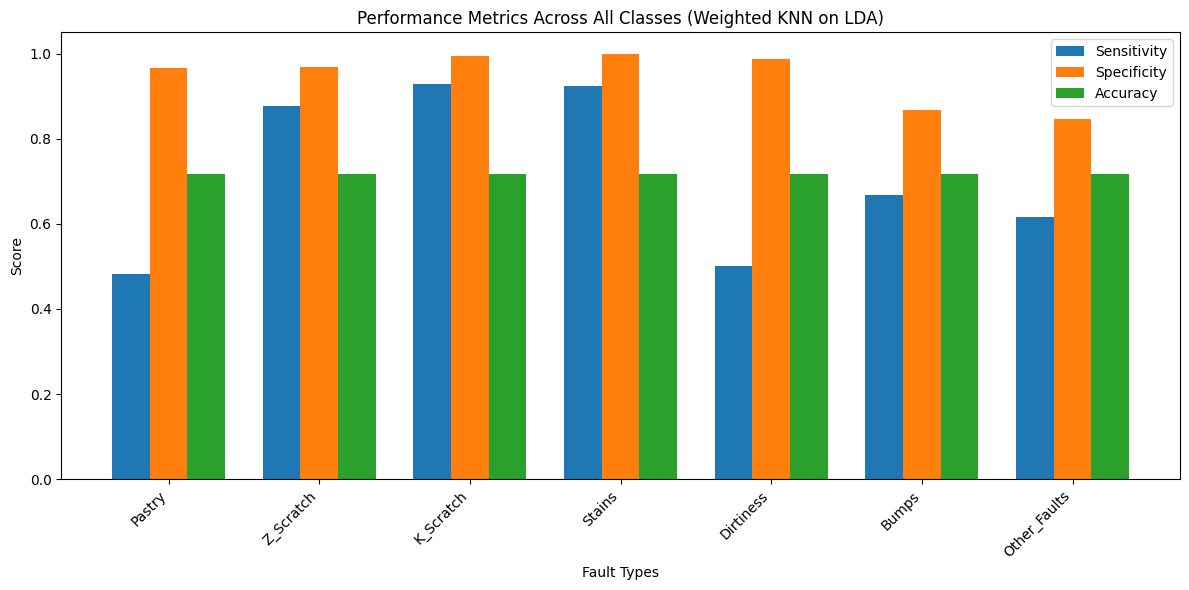

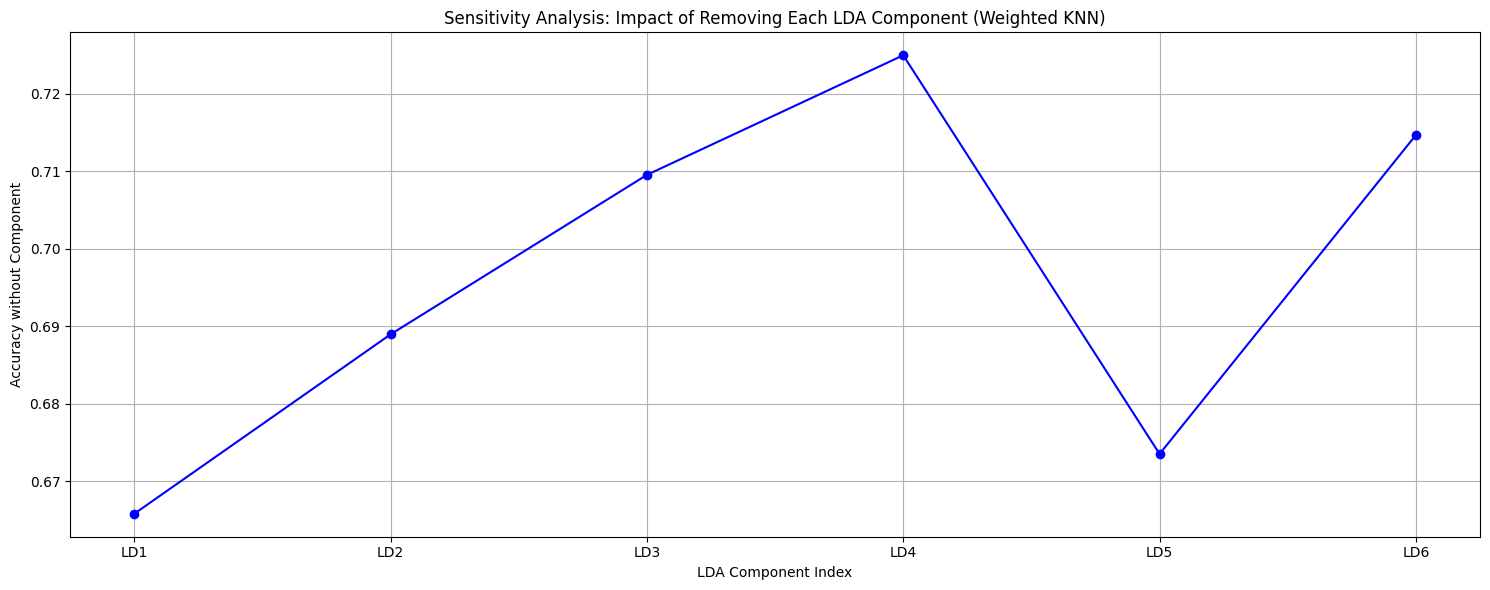

<Figure size 1200x600 with 0 Axes>

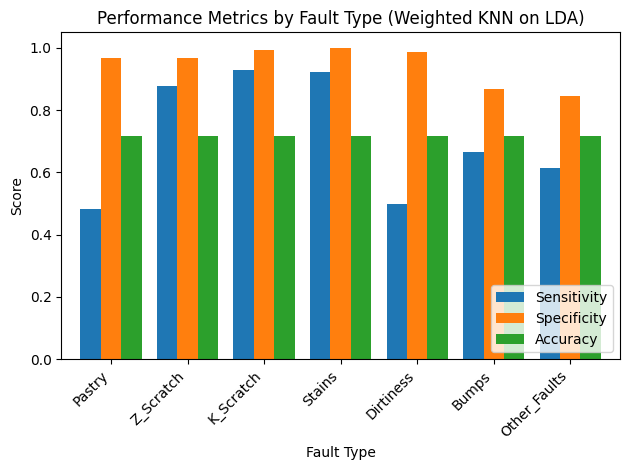

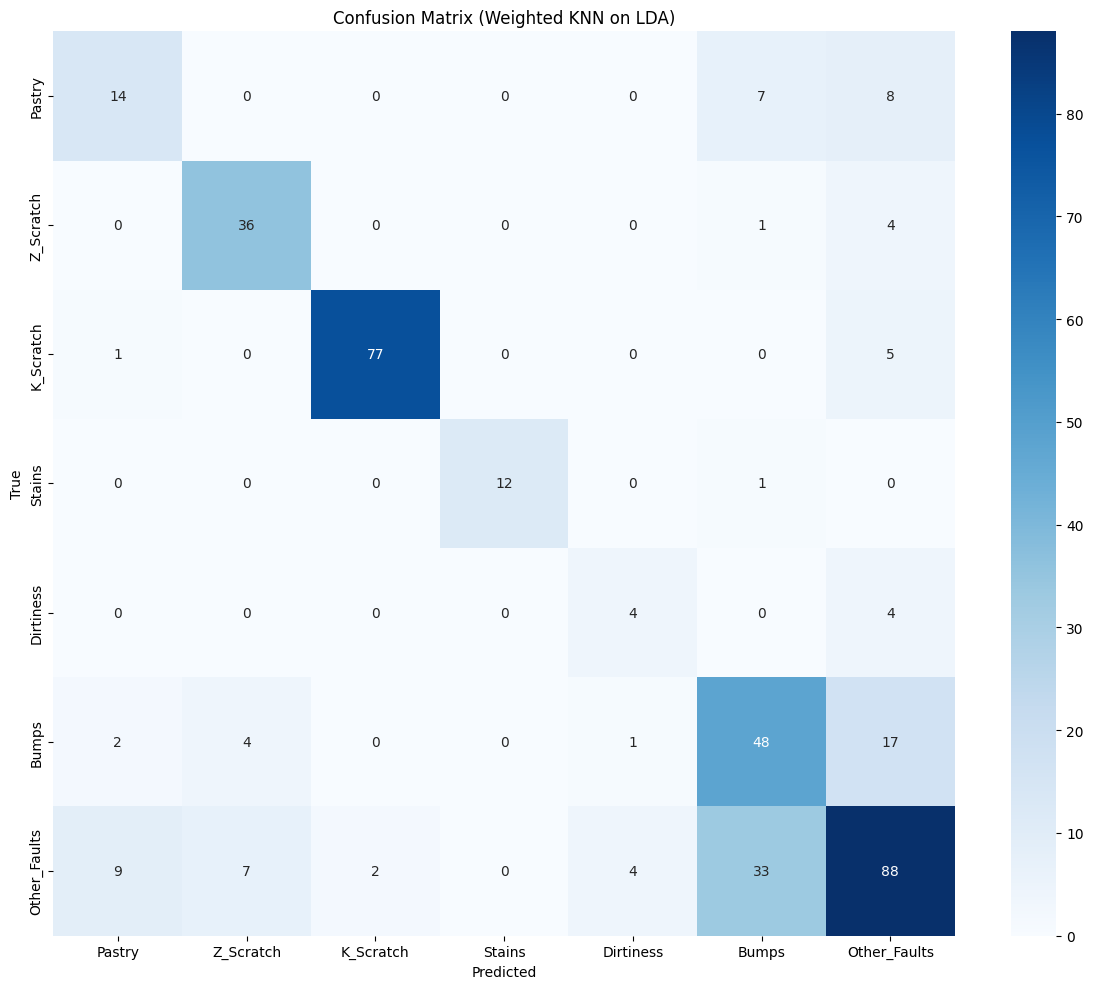

In [3]:

#WEIGHTED KNN LDA

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load LDA transformed dataset
file_path = 'lda_transformed.csv'
data = pd.read_csv(file_path)

# Separate features (LD components) and target variables (one-hot encoded classes)
feature_columns = ['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6']
class_columns = ["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

X = data[feature_columns].values
y = data[class_columns].values

# Convert one-hot encoded y to class labels
y_labels = np.argmax(y, axis=1)

def plot_overall_metrics(sensitivity_dict, specificity_dict, accuracy):
    """Plot overall metrics across all classes."""
    plt.figure(figsize=(12, 6))
    
    classes = list(sensitivity_dict.keys())
    sensitivities = [sensitivity_dict[c] for c in classes]
    specificities = [specificity_dict[c] for c in classes]
    accuracies = [accuracy] * len(classes)
    
    x = np.arange(len(classes))
    width = 0.25
    
    plt.bar(x - width, sensitivities, width, label='Sensitivity')
    plt.bar(x, specificities, width, label='Specificity')
    plt.bar(x + width, accuracies, width, label='Accuracy')
    
    plt.xlabel('Fault Types')
    plt.ylabel('Score')
    plt.title('Performance Metrics Across All Classes (Weighted KNN on LDA)')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_sensitivity_analysis(sensitivity_results):
    """Plot sensitivity analysis results for LDA components."""
    plt.figure(figsize=(15, 6))
    
    feature_indices = [r['Feature Index'] for r in sensitivity_results]
    accuracies = [r['Accuracy'] for r in sensitivity_results]
    
    plt.plot(feature_indices, accuracies, 'bo-')
    plt.xlabel('LDA Component Index')
    plt.ylabel('Accuracy without Component')
    plt.title('Sensitivity Analysis: Impact of Removing Each LDA Component (Weighted KNN)')
    plt.xticks(feature_indices, [f'LD{i+1}' for i in feature_indices])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fault_performance(sensitivity_dict, specificity_dict, accuracy):
    """Plot performance metrics per fault type."""
    metrics_df = pd.DataFrame({
        'Fault Type': list(sensitivity_dict.keys()),
        'Sensitivity': list(sensitivity_dict.values()),
        'Specificity': list(specificity_dict.values()),
        'Accuracy': [accuracy] * len(sensitivity_dict)
    })
    
    plt.figure(figsize=(12, 6))
    metrics_df.set_index('Fault Type').plot(kind='bar', width=0.8)
    plt.title('Performance Metrics by Fault Type (Weighted KNN on LDA)')
    plt.xlabel('Fault Type')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, class_labels):
    """Plot comprehensive confusion matrix."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix (Weighted KNN on LDA)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Find optimal k
optimal_k = 1
highest_accuracy = 0

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')  # Using distance-based weights
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    
    if mean_accuracy > highest_accuracy:
        highest_accuracy = mean_accuracy
        optimal_k = k

print(f"Optimal k: {optimal_k} with cross-validated accuracy: {highest_accuracy:.4f}")

# Train model with optimal k
knn = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')  # Using distance-based weights
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate sensitivity and specificity
sensitivity = {}
specificity = {}
for i, class_label in enumerate(class_columns):
    TP = conf_matrix[i, i]
    FN = sum(conf_matrix[i, :]) - TP
    FP = sum(conf_matrix[:, i]) - TP
    TN = conf_matrix.sum() - (TP + FN + FP)
    
    sensitivity[class_label] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_label] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print overall metrics
print("\nOverall Performance Metrics:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro-averaged Sensitivity: {np.mean(list(sensitivity.values())):.4f}")
print(f"Macro-averaged Specificity: {np.mean(list(specificity.values())):.4f}")

# Print per-class metrics
print("\nPer-Class Performance Metrics:")
print(f"{'Class':<15}{'Sensitivity':<15}{'Specificity':<15}")
print("-" * 45)
for class_label in class_columns:
    print(f"{class_label:<15}{sensitivity[class_label]:<15.4f}{specificity[class_label]:<15.4f}")

# Perform sensitivity analysis on LDA components
sensitivity_results = []
for feature_index in range(X.shape[1]):
    X_train_modified = np.delete(X_train, feature_index, axis=1)
    X_test_modified = np.delete(X_test, feature_index, axis=1)
    
    knn.fit(X_train_modified, y_train)
    y_pred_modified = knn.predict(X_test_modified)
    modified_accuracy = accuracy_score(y_test, y_pred_modified)
    
    sensitivity_results.append({
        'Feature Index': feature_index,
        'Accuracy': modified_accuracy
    })

# Create visualizations
plot_overall_metrics(sensitivity, specificity, accuracy)
plot_sensitivity_analysis(sensitivity_results)
plot_fault_performance(sensitivity, specificity, accuracy)
plot_confusion_matrix(conf_matrix, class_columns)

2024-12-28 21:49:15,798 - INFO - Dataset loaded successfully with shape: (1941, 13)
2024-12-28 21:49:16,646 - INFO - Model training completed after 33 iterations



Overall Performance Metrics:
Overall Accuracy: 0.7301
Macro-averaged Sensitivity: 0.7179
Macro-averaged Specificity: 0.9494

Per-Class Performance Metrics:
              Sensitivity  Specificity  Accuracy
Class                                           
Pastry             0.5938       0.9608    0.9306
Z_Scratch          0.8684       0.9630    0.9537
K_Scratch          0.9744       0.9871    0.9846
Stains             0.9286       1.0000    0.9974
Dirtiness          0.3636       0.9868    0.9692
Bumps              0.6667       0.9058    0.8560
Other_Faults       0.6296       0.8425    0.7686


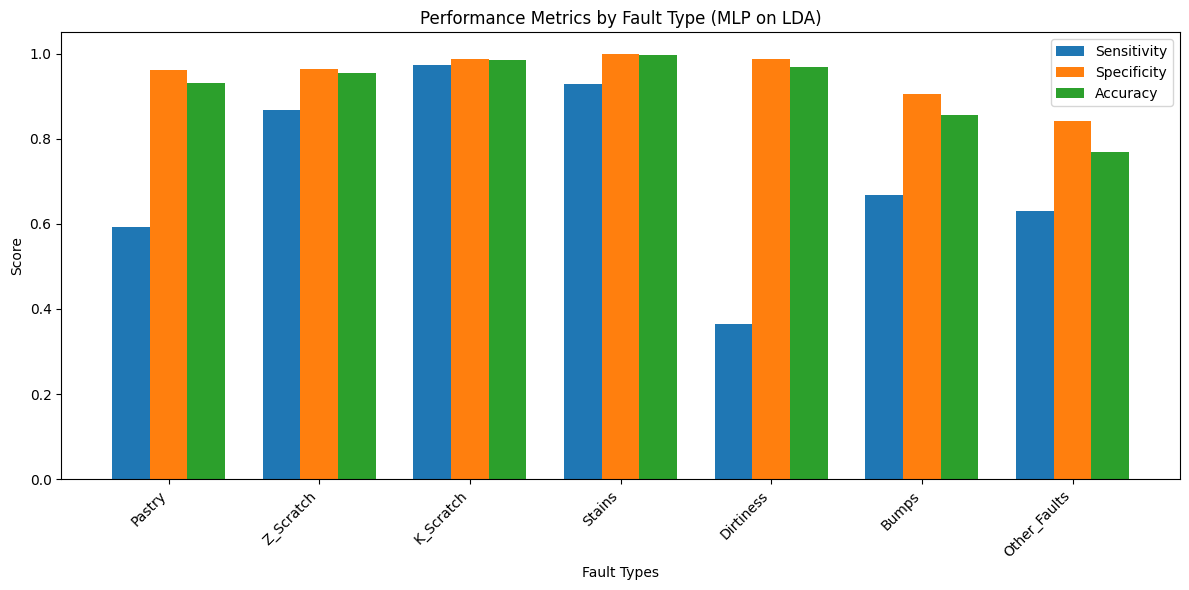

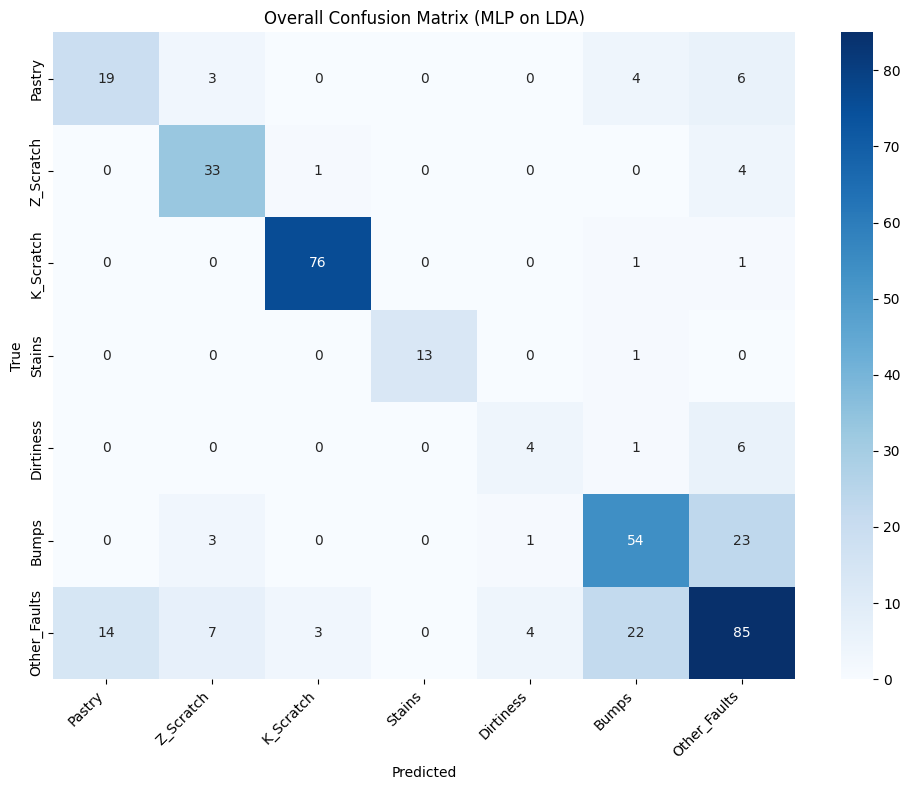

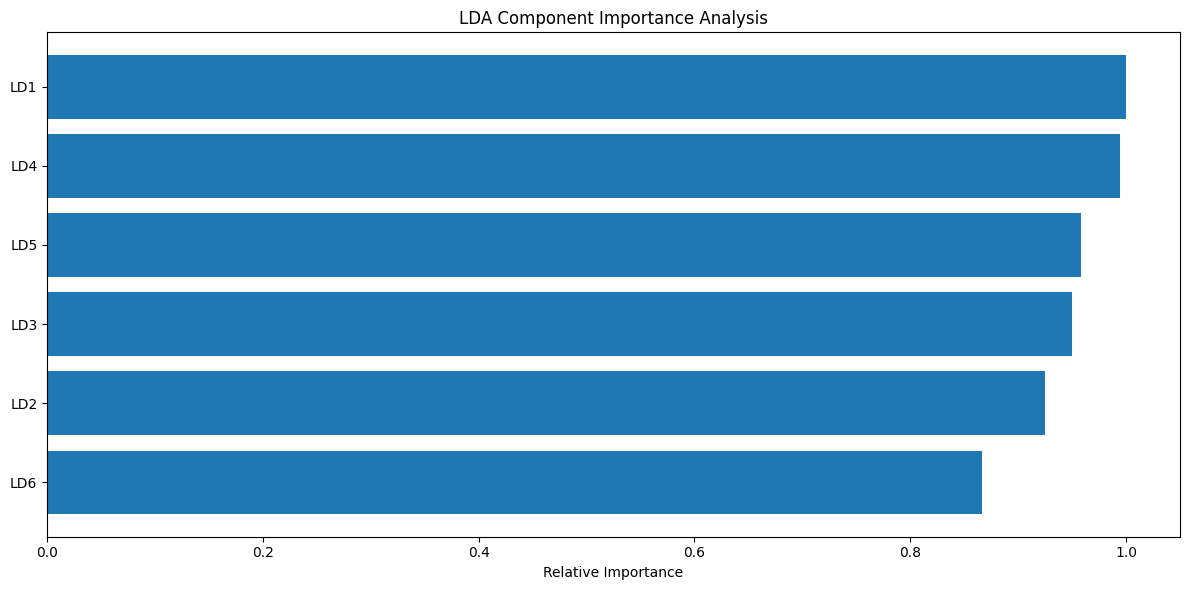

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def plot_overall_confusion_matrix(y_test, y_pred, class_names):
    """Plot single confusion matrix for all classes."""
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Overall Confusion Matrix (MLP on LDA)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance based on LDA components."""
    importance = np.zeros(len(feature_names))
    for layer in model.coefs_:
        importance += np.sum(np.abs(layer), axis=1)[:len(feature_names)]
    
    importance = importance / np.max(importance)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(importance_df)), importance_df['Importance'])
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Relative Importance')
    plt.title('LDA Component Importance Analysis')
    plt.tight_layout()
    plt.show()

def load_and_preprocess_data(file_path):
    """Load and preprocess the LDA transformed dataset."""
    try:
        if not Path(file_path).exists():
            raise FileNotFoundError(f"Dataset not found at {file_path}")
            
        data = pd.read_csv(file_path)
        logger.info(f"Dataset loaded successfully with shape: {data.shape}")
        
        # Separate features (LD components) and target variables
        feature_columns = ['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6']
        class_columns = ["Pastry", "Z_Scratch", "K_Scratch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
        
        X = data[feature_columns]
        y = data[class_columns]
        
        # Convert one-hot encoded y to class labels
        y_labels = np.argmax(y.values, axis=1)
        
        return X, y_labels, class_columns
        
    except Exception as e:
        logger.error(f"Error in data loading/preprocessing: {str(e)}")
        raise

def train_model(X_train, y_train):
    """Train the neural network model."""
    try:
        mlp = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size='auto',
            learning_rate='adaptive',
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42
        )
        
        mlp.fit(X_train, y_train)
        logger.info(f"Model training completed after {mlp.n_iter_} iterations")
        
        return mlp
        
    except Exception as e:
        logger.error(f"Error in model training: {str(e)}")
        raise

def calculate_metrics(y_true, y_pred, n_classes):
    """Calculate sensitivity and specificity for multiclass classification."""
    sensitivity = {}
    specificity = {}
    
    for i in range(n_classes):
        # Convert to binary classification problem for each class
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        sensitivity[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return sensitivity, specificity

def plot_metrics(metrics_df):
    """Plot sensitivity, specificity, and accuracy for each class."""
    plt.figure(figsize=(12, 6))
    
    barWidth = 0.25
    r1 = np.arange(len(metrics_df))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.bar(r1, metrics_df['Sensitivity'], width=barWidth, label='Sensitivity')
    plt.bar(r2, metrics_df['Specificity'], width=barWidth, label='Specificity')
    plt.bar(r3, metrics_df['Accuracy'], width=barWidth, label='Accuracy')
    
    plt.xlabel('Fault Types')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Fault Type (MLP on LDA)')
    plt.xticks([r + barWidth for r in range(len(metrics_df))], metrics_df.index, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, class_names):
    """Evaluate the model and visualize results."""
    try:
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        sensitivity_dict, specificity_dict = calculate_metrics(y_test, y_pred, len(class_names))
        
        # Create metrics DataFrame
        metrics_data = []
        for i, class_name in enumerate(class_names):
            metrics_data.append({
                'Class': class_name,
                'Sensitivity': sensitivity_dict[i],
                'Specificity': specificity_dict[i],
                'Accuracy': accuracy_score(y_test == i, y_pred == i)
            })
        
        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.set_index('Class', inplace=True)
        
        # Calculate overall metrics
        overall_sensitivity = np.mean(list(sensitivity_dict.values()))
        overall_specificity = np.mean(list(specificity_dict.values()))
        overall_accuracy = accuracy_score(y_test, y_pred)
        
        # Print metrics
        print("\nOverall Performance Metrics:")
        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print(f"Macro-averaged Sensitivity: {overall_sensitivity:.4f}")
        print(f"Macro-averaged Specificity: {overall_specificity:.4f}")
        
        print("\nPer-Class Performance Metrics:")
        print(metrics_df.round(4))
        
        # Plot metrics
        plot_metrics(metrics_df)
        plot_overall_confusion_matrix(y_test, y_pred, class_names)
        plot_feature_importance(model, X_test.columns)
        
        return overall_accuracy, y_pred, metrics_df
        
    except Exception as e:
        logger.error(f"Error in model evaluation: {str(e)}")
        raise

def main():
    """Main function to run the classification pipeline."""
    try:
        # Load and preprocess data
        X, y, class_names = load_and_preprocess_data('lda_transformed.csv')
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train model
        model = train_model(X_train, y_train)
        
        # Evaluate model
        accuracy, predictions, metrics = evaluate_model(model, X_test, y_test, class_names)
        
        return model, accuracy, predictions, metrics
        
    except Exception as e:
        logger.error(f"Error in main pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    main()